# The Battle of Neighborhoods

## Introduction & Business Problem

### Introduction 
New York City is the most diverse and populated city in the United States (the city has a population density of over 27,000 people per square mile). In New York, you’ll find almost every race and language you can think of under the sun, hence the common moniker, “the melting pot of the world.” The city is made up of 5 boroughs: Manhattan, Brooklyn, Queens, the Bronx and Staten Island, all of which were “grouped” together into a single city in 1898.

Due to the prosperity and grandeur of New York City resulting in people from many countries want to come to New York City whether coming to work or coming to study. Many Thai people also have come to New York for traveling, working, and studying that make Thai food is one of the popular foods in New York City.

### Business Problem
Because many Thai people come to live in New York City. These people usually eat Thai food in their everyday life so they need to live in the area that has many Thai restaurants so that they can easily find a good Thai food.

In addition, there are also many group of tourists whether Thai tourists who miss their home country food, people from other countries who like Thai food or even people who want to try Thai food would like to know information about which area in New York has many Thai restaurants so that there are many options for them.

Therefore, I will solve this problem by answer the questions as following:
1. Which neighborhood in New York City have the most Thai restaurants?
2. Which neighborhood in New York City have the best average rating for Thai restaurants?

### Target Audience
- Main target audience is Thai people who living in New York City want to live in an area with a variety of Thai restaurants.
- Secondary target audience is tourists who interested in Thai food.

## Data Section

### New York City Neighborhoods Data
I will use New York City neighborhoods dataset that published from New York (City). Department of City Planning on the following url:

https://geo.nyu.edu/catalog/nyu_2451_34572 

This dataset contains 5 boroughs and 306 neighborhoods that exist in each borough as well as the latitude and the longitude coordinates of each neighborhood.

In this dataset, I will extract borough, neighborhood, latitude and longitude to visualize the data New York City map.

### Thai Restaurants Data
I will use Foursquare API which is well-known location data provider to extract venue data for Thai restaurant in New York City using Thai Restaurant (4bf58dd8d48988d149941735) venue category.

## Methodology
1. Extract borough, neighborhood, latitude and longitude of New York City from https://geo.nyu.edu/catalog/nyu_2451_34572
2. Convert data into pandas dataframe format for easy to analyze.
3. Let's see the example of the data, shape and descriptive statistics.
4. Extract Thai restuarants data in each neighborhood from Foursqare API
5. Convert data into pandas dataframe and csv.
6. Let's see the example of the data, shape and descriptive statistics.
7. Visualize the data the answer the questions.

Firstly, let's import nescessary libraries.

In [17]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Extract data from newyork_data.json

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Convert json to dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Let's see the example of the data.

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Then, extract Thai restuarants data from Foursquare API.

In [12]:
def get_venues(lat,lng):
    
    #set variables
    CLIENT_ID = '2YZ3UDVZXAD4ODFRVNPW0FJ1D31LRWJH1RTFTH5GG0YNIQJE' # your Foursquare ID
    CLIENT_SECRET = 'ZM45XKPONM4XO2AYSNVNKCDZVC24QF1YRLZBVM32N52VDYKC' # your Foursquare Secret
    VERSION = '20200424' # Foursquare API version
    LIMIT = 500
    radius = 500
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [13]:
# prepare neighborhood list that contains Thai resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
thai_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    thai_resturants=venues[venues['Category']=='Thai Restaurant']   
    print('(',count,'/',len(neighborhoods),')','Thai Resturants in '+Neighborhood+', '+Borough+':'+str(len(thai_resturants)))
    for resturant_detail in thai_resturants.values.tolist():
        id, name , category=resturant_detail
        thai_rest_ny = thai_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Thai Resturants in Wakefield, Bronx:0
( 2 / 306 ) Thai Resturants in Co-op City, Bronx:0
( 3 / 306 ) Thai Resturants in Eastchester, Bronx:0
( 4 / 306 ) Thai Resturants in Fieldston, Bronx:0
( 5 / 306 ) Thai Resturants in Riverdale, Bronx:0
( 6 / 306 ) Thai Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Thai Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Thai Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Thai Resturants in Norwood, Bronx:0
( 10 / 306 ) Thai Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Thai Resturants in Baychester, Bronx:0
( 12 / 306 ) Thai Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Thai Resturants in City Island, Bronx:0
( 14 / 306 ) Thai Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Thai Resturants in University Heights, Bronx:0
( 16 / 306 ) Thai Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Thai Resturants in Fordham, Bronx:0
( 18 / 306 ) Thai Resturants in East Tremont, Bronx:0
( 19 / 306 ) Thai Resturants in West Farms, Bronx:0


( 148 / 306 ) Thai Resturants in Ozone Park, Queens:0
( 149 / 306 ) Thai Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Thai Resturants in College Point, Queens:0
( 151 / 306 ) Thai Resturants in Whitestone, Queens:0
( 152 / 306 ) Thai Resturants in Bayside, Queens:1
( 153 / 306 ) Thai Resturants in Auburndale, Queens:1
( 154 / 306 ) Thai Resturants in Little Neck, Queens:1
( 155 / 306 ) Thai Resturants in Douglaston, Queens:0
( 156 / 306 ) Thai Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Thai Resturants in Bellerose, Queens:0
( 158 / 306 ) Thai Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Thai Resturants in Fresh Meadows, Queens:1
( 160 / 306 ) Thai Resturants in Briarwood, Queens:0
( 161 / 306 ) Thai Resturants in Jamaica Center, Queens:0
( 162 / 306 ) Thai Resturants in Oakland Gardens, Queens:0
( 163 / 306 ) Thai Resturants in Queens Village, Queens:0
( 164 / 306 ) Thai Resturants in Hollis, Queens:1
( 165 / 306 ) Thai Resturants in South Jamaica, Queens:0
( 

( 289 / 306 ) Thai Resturants in Roxbury, Queens:0
( 290 / 306 ) Thai Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Thai Resturants in Middle Village, Queens:0
( 292 / 306 ) Thai Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Thai Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Thai Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Thai Resturants in Malba, Queens:0
( 296 / 306 ) Thai Resturants in Highland Park, Brooklyn:0
( 297 / 306 ) Thai Resturants in Madison, Brooklyn:0
( 298 / 306 ) Thai Resturants in Bronxdale, Bronx:0
( 299 / 306 ) Thai Resturants in Allerton, Bronx:0
( 300 / 306 ) Thai Resturants in Kingsbridge Heights, Bronx:0
( 301 / 306 ) Thai Resturants in Erasmus, Brooklyn:0
( 302 / 306 ) Thai Resturants in Hudson Yards, Manhattan:0
( 303 / 306 ) Thai Resturants in Hammels, Queens:0
( 304 / 306 ) Thai Resturants in Bayswater, Queens:0
( 305 / 306 ) Thai Resturants in Queensbridge, Queens:0
( 306 / 306 ) Thai Resturants in Fox Hills,

Let's see the example of Thai restuarants.

In [14]:
thai_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4dc5d0b47d8b14fb463525e9,Accent Thai
1,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine
2,Bronx,Van Nest,5585c948498e0bd8a8a706f1,Thai Cuisine
3,Bronx,North Riverdale,4dc5d0b47d8b14fb463525e9,Accent Thai
4,Bronx,Pelham Bay,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion


We found 66 Thai restuarants in New York City.

In [15]:
thai_rest_ny.shape

(66, 4)

Keep data into csv to prevent API limit.

In [39]:
thai_rest_ny.to_csv('thai_rest_ny.csv', index=False)

In [40]:
thai_rest_ny_csv = pd.read_csv('thai_rest_ny.csv')

In [41]:
thai_rest_ny_csv.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4dc5d0b47d8b14fb463525e9,Accent Thai
1,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine
2,Bronx,Van Nest,5585c948498e0bd8a8a706f1,Thai Cuisine
3,Bronx,North Riverdale,4dc5d0b47d8b14fb463525e9,Accent Thai
4,Bronx,Pelham Bay,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion


In [42]:
thai_rest_ny_csv.shape

(66, 4)

Let's see which borough has the most Thai restaurants.

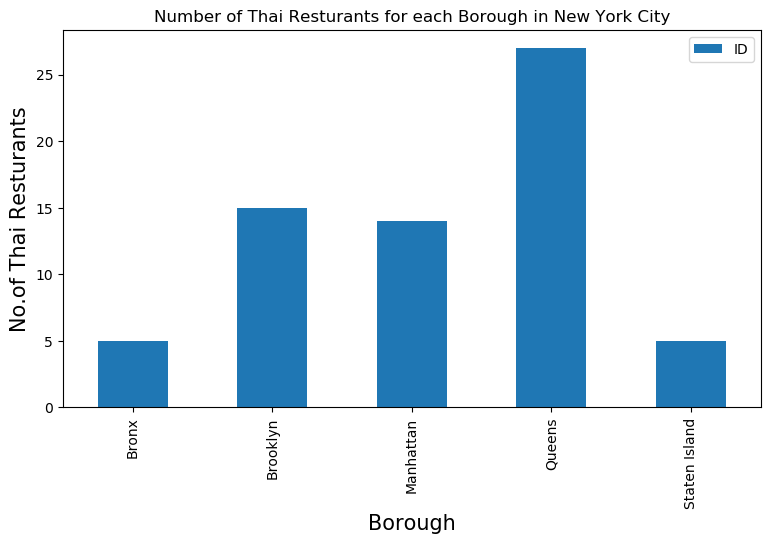

In [43]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Thai Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Thai Resturants', fontsize=15)
#giving a bar plot
thai_rest_ny_csv.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We found that Queens has the most Thai restaurants in New York City. Then let's see which neighborhood has the most Thai restaurants.

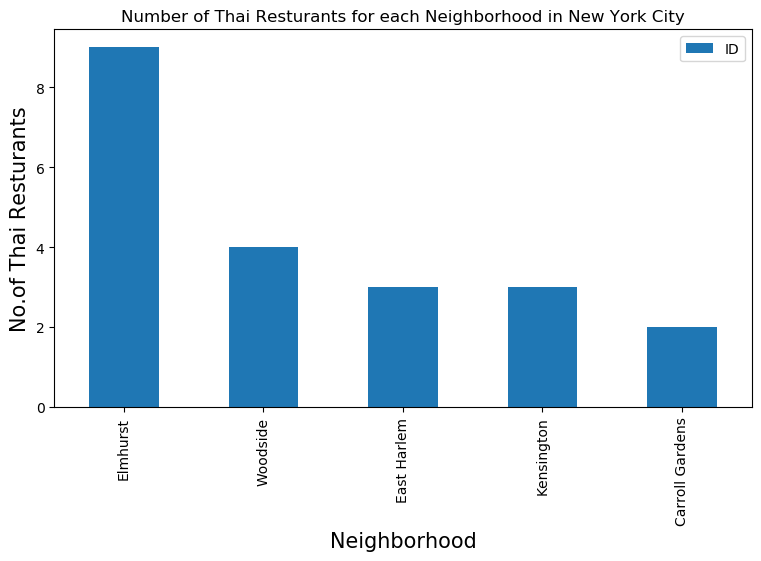

In [24]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Thai Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Thai Resturants', fontsize=15)
#giving a bar plot
thai_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

So, we found that Elmhurst has 9 Thai restaurants which is the most in New York City.

In [44]:
thai_rest_ny_csv[thai_rest_ny_csv['Neighborhood']=='Elmhurst']

,Borough,Neighborhood,ID,Name
37,Queens,Elmhurst,52f693e6498ed9d2a3fbad75,Eim Khao Mun Kai Elmhurst อิ่ม ข้าวมันไก่เอ็มเ...
38,Queens,Elmhurst,5abad6379de23b5eeb077b04,Lamoon
39,Queens,Elmhurst,56e210f7cd102122a9fb1d1b,Dek Sen
40,Queens,Elmhurst,4ad5173cf964a520c90121e3,Chao Thai ร้านชาวไทย
41,Queens,Elmhurst,4b26f895f964a5209d8324e3,Ayada Thai
42,Queens,Elmhurst,593f6541123a19687791b390,Hug Esan NYC
43,Queens,Elmhurst,531372e9498ebd3be2888afc,Khao Kang ข้าวแกง
44,Queens,Elmhurst,4ad15d63f964a5203ede20e3,Spicy Shallot
45,Queens,Elmhurst,53af884e498e0a4a4943f670,Kitchen 79


Let's get more insight on each restaurant (Rating, Tips, Like) from Foursquare API.

In [28]:
def get_venue_details(venue_id):
    #set variables
    CLIENT_ID = '2YZ3UDVZXAD4ODFRVNPW0FJ1D31LRWJH1RTFTH5GG0YNIQJE' # your Foursquare ID
    CLIENT_SECRET = 'ZM45XKPONM4XO2AYSNVNKCDZVC24QF1YRLZBVM32N52VDYKC' # your Foursquare Secret
    VERSION = '20200424' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [45]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
thai_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in thai_rest_ny_csv.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(thai_rest_ny_csv),')','processed')
    thai_rest_stats_ny = thai_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID         Name  Likes  Rating  Tips
0  4dc5d0b47d8b14fb463525e9  Accent Thai     14     8.4     4
( 1 / 66 ) processed
                         ID          Name  Likes  Rating  Tips
0  5585c948498e0bd8a8a706f1  Thai Cuisine     17     7.5     1
( 2 / 66 ) processed
                         ID          Name  Likes  Rating  Tips
0  5585c948498e0bd8a8a706f1  Thai Cuisine     17     7.5     1
( 3 / 66 ) processed
                         ID         Name  Likes  Rating  Tips
0  4dc5d0b47d8b14fb463525e9  Accent Thai     14     8.4     4
( 4 / 66 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4b4c90d3f964a52046b626e3  Honey's Thai Pavilion     19     7.2    28
( 5 / 66 ) processed
                         ID          Name  Likes  Rating  Tips
0  596ffbcadee77066f36be772  Ruammit Thai     24     8.5     5
( 6 / 66 ) processed
                         ID                  Name  Likes  Rating  Tips
0  54daa265498e58e310cae373  Sawa

                         ID             Name  Likes  Rating  Tips
0  46b1ef0df964a520a0491fe3  Bangkok Cuisine     61     8.5    33
( 56 / 66 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4b7c698af964a520bc912fe3  Forest Thai Cuisine     13     7.7    20
( 57 / 66 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4b7c698af964a520bc912fe3  Forest Thai Cuisine     13     7.7    20
( 58 / 66 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4b7c698af964a520bc912fe3  Forest Thai Cuisine     13     7.7    20
( 59 / 66 ) processed
                         ID                      Name  Likes  Rating  Tips
0  51734440e4b093690645e66b  Empire East Richmond Ave      7     7.3     5
( 60 / 66 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4b7c698af964a520bc912fe3  Forest Thai Cuisine     13     7.7    20
( 61 / 66 ) processed
                         I

Let's see the example of the data.

In [46]:
thai_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4dc5d0b47d8b14fb463525e9,Accent Thai,14,8.4,4
1,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.5,1
2,Bronx,Van Nest,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.5,1
3,Bronx,North Riverdale,4dc5d0b47d8b14fb463525e9,Accent Thai,14,8.4,4
4,Bronx,Pelham Bay,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.2,28


In [47]:
thai_rest_stats_ny.shape

(66, 7)

In [48]:
thai_rest_stats_ny.to_csv('thai_rest_stats_ny.csv', index=False)

In [49]:
thai_rest_stats_ny_csv=pd.read_csv('thai_rest_stats_ny.csv')

In [50]:
thai_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4dc5d0b47d8b14fb463525e9,Accent Thai,14,8.4,4
1,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.5,1
2,Bronx,Van Nest,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.5,1
3,Bronx,North Riverdale,4dc5d0b47d8b14fb463525e9,Accent Thai,14,8.4,4
4,Bronx,Pelham Bay,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.2,28


In [51]:
thai_rest_stats_ny_csv.shape

(66, 7)

In [52]:
thai_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       66 non-null     object 
 1   Neighborhood  66 non-null     object 
 2   ID            66 non-null     object 
 3   Name          66 non-null     object 
 4   Likes         66 non-null     int64  
 5   Rating        66 non-null     float64
 6   Tips          66 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 3.7+ KB


Convert tips data type from string to float for easy to analyze.

In [53]:
thai_rest_stats_ny['Likes']=thai_rest_stats_ny['Likes'].astype('float64')
thai_rest_stats_ny['Tips']=thai_rest_stats_ny['Tips'].astype('float64')

In [55]:
thai_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       66 non-null     object 
 1   Neighborhood  66 non-null     object 
 2   ID            66 non-null     object 
 3   Name          66 non-null     object 
 4   Likes         66 non-null     float64
 5   Rating        66 non-null     float64
 6   Tips          66 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.7+ KB


Restaurant with maximum Likes

In [57]:
# Restaurant with maximum Likes
thai_rest_stats_ny.iloc[thai_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              516863b1011ca6684e37a88f
Name                         Uncle Boons
Likes                               1016
Rating                               9.1
Tips                                 330
Name: 29, dtype: object

Restaurant with maximum Rating

In [58]:
# Restaurant with maximum Rating
thai_rest_stats_ny.iloc[thai_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              5cc4e9d0c876c8002c3010cb
Name                               Wayla
Likes                                126
Rating                               9.2
Tips                                  26
Name: 20, dtype: object

Restaurant with maximum Tips

In [59]:
# Restaurant with maximum Tips
thai_rest_stats_ny.iloc[thai_rest_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood                    Woodside
ID              3fd66200f964a5204ef11ee3
Name                          SriPraPhai
Likes                                766
Rating                               8.9
Tips                                 357
Name: 31, dtype: object

Let's summarize average rating of Thai restaurants in each neighborhood.

In [60]:
ny_neighborhood_stats=thai_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [61]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
6,Chinatown,9.20
23,Lenox Hill,9.05
2,Boerum Hill,9.00
9,Downtown,9.00
44,Yorkville,8.90
35,South Ozone Park,8.90
34,Rochdale,8.90
25,Little Neck,8.90
24,Little Italy,8.85
33,Prospect Lefferts Gardens,8.80


Let's summarize average rating of Thai restuarants in each borough.

In [62]:
ny_borough_stats=thai_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [63]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.557143
1,Brooklyn,8.540000
3,Queens,8.325926
0,Bronx,7.800000
4,Staten Island,7.620000


Visualize average rating of Thai restuarants for each borough.

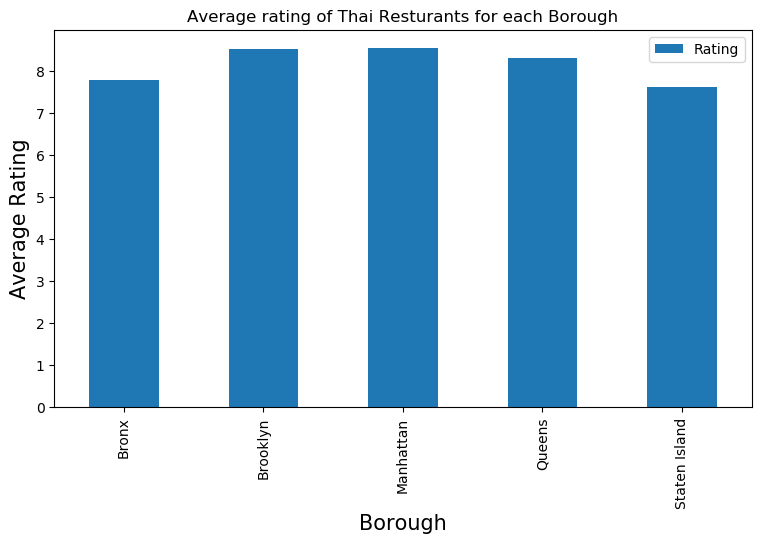

In [78]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Thai Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
thai_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Select only neighborhoods which average rating more than 9.0

In [65]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [66]:
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Boerum Hill,9.00
6,Chinatown,9.20
9,Downtown,9.00
23,Lenox Hill,9.05


Merge high average rating neighborhoods with their latitude and longitude to visualize in map.

In [67]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,neighborhoods, on='Neighborhood')

In [68]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [69]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,9.00
1,Manhattan,Chinatown,40.715618,-73.994279,9.20
2,Brooklyn,Downtown,40.690844,-73.983463,9.00
3,Manhattan,Lenox Hill,40.768113,-73.958860,9.05


Visualize the location of each neighborhood which highest average rating in the map.

In [71]:
address='New York City, NY'
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [72]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [74]:
# instantiate a feature group for the incidents in the dataframe
thai_res = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    thai_res.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [75]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [76]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(thai_res)